# Model v19_original

This model is a baseline for evaluating v19_attention. It is the same model, except the images do not have the attention region.

Path images, roughness metric = 1 second ahead, k-means 2, data split within sessions, the same images are used as v19 except these images do not have the attention region.

## Set-up

In [1]:
!pip install wandb

     |████████████████████████████████| 1.8MB 14.1MB/s 
     |████████████████████████████████| 133kB 49.6MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 163kB 48.8MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6490 sha256=3469e7db7a8b176c4aed2e76a37d8961caff10e737ae2374dd21c01b051d949a
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built subprocess32


In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 49.5MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [5]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='roughness-classifier-4')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model

#### Load data

In [7]:
path = '/gdrive/My Drive/Labeling/Model'
folder_path = os.path.join(path, 'attention_region', 'v19')
image_path = os.path.join(path, 'Images')
label_path = '/gdrive/My Drive/Labeling/LabelsCSV'

In [8]:
df = pd.read_csv(os.path.join(label_path, 'attention_region', 'labels_path_validated_mask_split_metric_2.csv'))
df = df.filter(items=['image', 'group_4', 'dataset'])

# Categorical data
df['group_4'] = df['group_4'].astype(int).astype(str)

# Create is_valid column
df['is_valid'] = df['dataset'] == 'valid'

# Training set, filter out dataset column
train = df[df['dataset'] == 'train'].filter(items=['image', 'group_4', 'is_valid'])

# Validation set, filter out dataset column
valid = df[df['dataset'] == 'valid'].filter(items=['image', 'group_4', 'is_valid'])

#### Balance classes

In [9]:
# Training set
group_0 = train[train['group_4'] == '0']
group_1 = train[train['group_4'] == '1']
group_2 = train[train['group_4'] == '2']
group_3 = train[train['group_4'] == '3']

print(len(group_0))
print(len(group_1))
print(len(group_2))
print(len(group_3))

1648
1267
529
145


In [11]:
group_0 = group_0[:1000]
group_1 = group_1[:1000]

train_balanced = group_0.append(group_1).append(group_2).append(group_3)

print(len(train_balanced))
print(len(train_balanced[train_balanced['group_4'] == '0']))
print(len(train_balanced[train_balanced['group_4'] == '1']))
print(len(train_balanced[train_balanced['group_4'] == '2']))
print(len(train_balanced[train_balanced['group_4'] == '3']))

2674
1000
1000
529
145


In [12]:
# Validation set
group_0_v = valid[valid['group_4'] == '0']
group_1_v = valid[valid['group_4'] == '1']
group_2_v = valid[valid['group_4'] == '2']
group_3_v = valid[valid['group_4'] == '3']

print(len(group_0_v))
print(len(group_1_v))
print(len(group_2_v))
print(len(group_3_v))

366
333
150
51


In [13]:
group_0_v = group_0_v[:298]
group_1_v = group_1_v[:298]

valid_balanced = group_0_v.append(group_1_v).append(group_2_v).append(group_3_v)

print(len(valid_balanced))
print(len(valid_balanced[valid_balanced['group_4'] == '0']))
print(len(valid_balanced[valid_balanced['group_4'] == '1']))
print(len(valid_balanced[valid_balanced['group_4'] == '2']))
print(len(valid_balanced[valid_balanced['group_4'] == '3']))

797
298
298
150
51


In [14]:
df_balanced = train_balanced.append(valid_balanced)
print(len(df_balanced))
print(len(df_balanced[df_balanced['is_valid'] == False]))
print(len(df_balanced[df_balanced['is_valid'] == True]))

3471
2674
797


In [15]:
df_balanced.head()

,image,group_4,is_valid
0,969905035s184ms.jpg,0,False
1,970588340s260ms.jpg,0,False
5,969902113s258ms.jpg,0,False
6,970588196s250ms.jpg,0,False
7,970588218s272ms.jpg,0,False


#### DataBunch

The original image size is 3840 x 2160. We resize (squish) to a smaller image with the same aspect ratio (270 x 480, decreased by a factor of 8) [Link](https://fastai1.fast.ai/vision.transform.html#Data-augmentation-details).

In [16]:
bs = 64

In [18]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=df_balanced)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_4')
        .transform(get_transforms(do_flip=False), size=(270,480))
        .databunch(bs=bs)
        .normalize())

In [19]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

2674 2674
797 797


In [20]:
print(data.classes)

['0', '1', '2', '3']


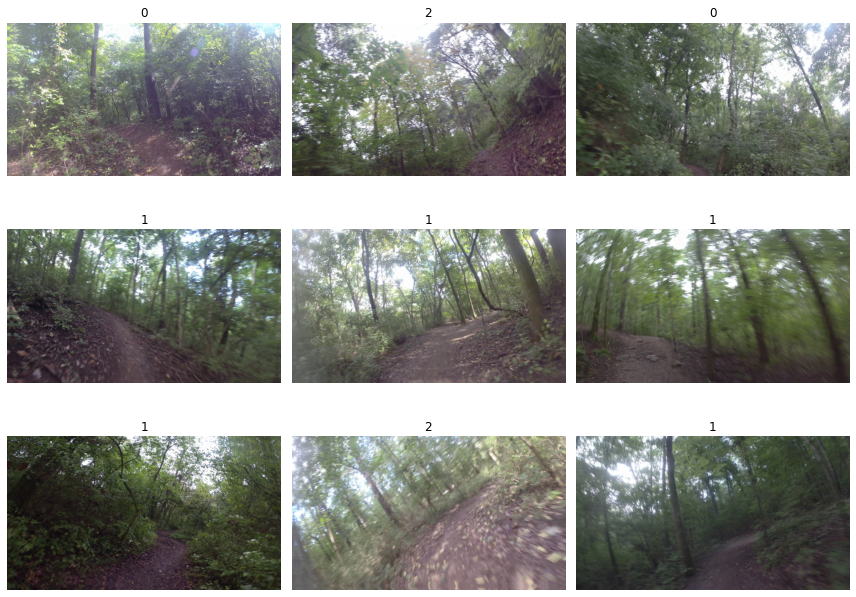

In [21]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet50

In [22]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=WandbCallback)
# learn = cnn_learner(data, arch, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


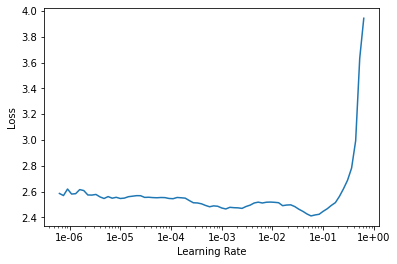

In [24]:
learn.recorder.plot()

In [25]:
lr = 0.01

In [26]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.239082,1.599591,0.440401,16:25
1,1.690310,1.424117,0.410289,13:04
2,1.415974,1.221653,0.462986,13:06
3,1.252810,1.277439,0.414053,12:58
4,1.136167,1.169787,0.464241,13:08


Better model found at epoch 0 with valid_loss value: 1.599590539932251.
Better model found at epoch 1 with valid_loss value: 1.4241169691085815.
Better model found at epoch 2 with valid_loss value: 1.221652626991272.
Better model found at epoch 4 with valid_loss value: 1.1697872877120972.
Loaded best saved model from /content/wandb/run-20210107_193249-30g1v24m/files/bestmodel.pth


In [27]:
learn.save(os.path.join(folder_path, 'v19-original-stage-1'))

In [28]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.112640,1.349617,0.454203,13:07
1,1.125181,1.277429,0.468005,13:24


Better model found at epoch 0 with valid_loss value: 1.349616527557373.
Better model found at epoch 1 with valid_loss value: 1.277429223060608.
Loaded best saved model from /content/wandb/run-20210107_193249-30g1v24m/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v19-original-stage-1'))

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

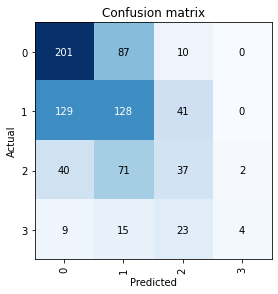

In [31]:
interp.plot_confusion_matrix()

#### Fine-tune

In [ ]:
learn.load(os.path.join(folder_path, 'v19-original-stage-1'))

In [33]:
learn.data.batch_size = 16

In [34]:
learn.data.batch_size

16

In [35]:
learn.unfreeze()

In [36]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


Loaded best saved model from /content/wandb/run-20210107_193249-30g1v24m/files/bestmodel.pth
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


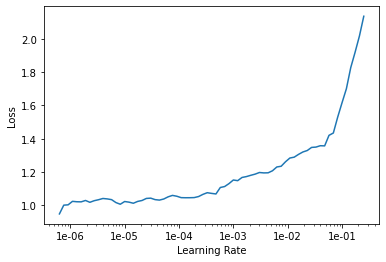

In [37]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.043400,1.160739,0.474279,13:38
1,1.060392,1.184836,0.446675,12:58
2,1.020749,1.158116,0.444166,13:19
3,0.983385,1.176281,0.451694,13:30
4,0.919704,1.172232,0.445420,13:42


Better model found at epoch 0 with valid_loss value: 1.1607389450073242.
Better model found at epoch 2 with valid_loss value: 1.1581164598464966.
Loaded best saved model from /content/wandb/run-20210107_193249-30g1v24m/files/bestmodel.pth


In [39]:
learn.save(os.path.join(folder_path, 'v19-original-stage-2'))

In [45]:
learn.fit_one_cycle(2, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.981980,1.172478,0.459222,12:48
1,0.959111,1.204066,0.444166,12:56


Better model found at epoch 0 with valid_loss value: 1.1724780797958374.
Loaded best saved model from /content/wandb/run-20210107_193249-30g1v24m/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v19-original-stage-2'))

In [40]:
learn.freeze()

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

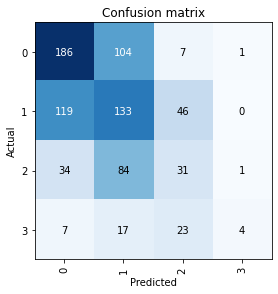

In [42]:
interp.plot_confusion_matrix()

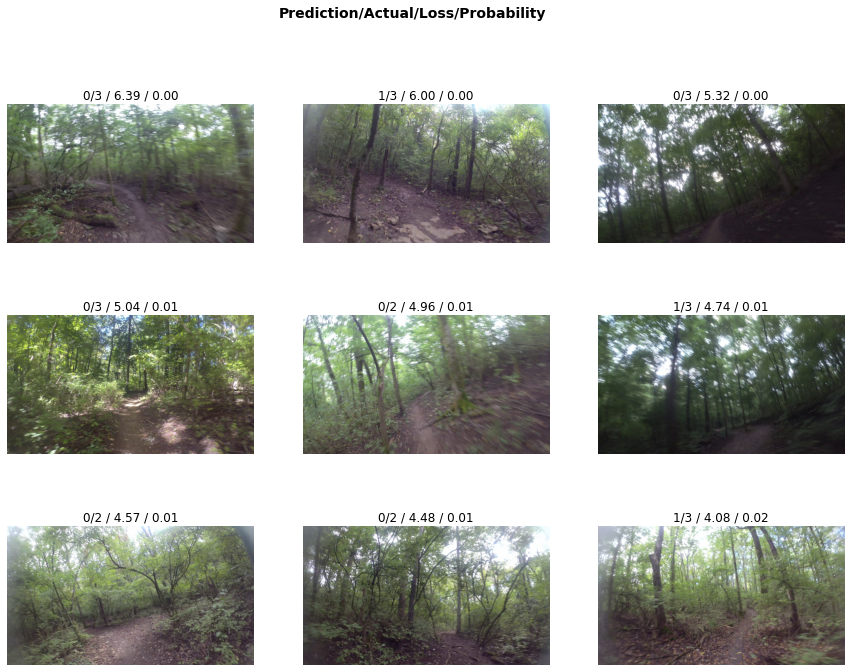

In [43]:
interp.plot_top_losses(9, figsize=(15,11))